In [269]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from qat.core import Observable, Term
from qat.plugins import SPSAMinimizePlugin, ScipyMinimizePlugin
from qat.qpus import get_default_qpu


import matplotlib
matplotlib.rcParams['text.usetex'] = True

# QAOA: Maximum Independent Set (MIS)

## Graph

In [270]:
# Random positions
n_nodes = 10
radius = 2
pos_list = np.random.rand(n_nodes, 2)*10

# Square lattice with missing nodes
# Lattice size
Lx, Ly = 5, 4
# Number of nodes in lattice
n_nodes = int(np.round(0.8*Lx*Ly))
# Radius of blockade
radius = 2**0.5+1e-3
lattice_pos_list = np.array([[i,j] for i in range(Lx) for j in range(Ly)])
np.random.shuffle(lattice_pos_list)
pos_list = lattice_pos_list[:n_nodes]



In [271]:
pos_list = pos_list_2

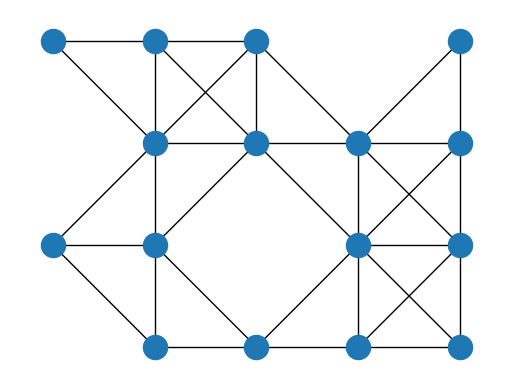

In [272]:
# Crate graph
graph = nx.Graph()
for i, pos in enumerate(pos_list):
    graph.add_node(i, pos = pos)
    
for i in range(n_nodes-1):
    for j in range(i+1, n_nodes):
        if np.linalg.norm(pos_list[i] - pos_list[j]) <= radius:
            graph.add_edge(i,j)

ax = plt.subplot()
ax.set_aspect('equal', 'box')
nx.draw(graph, pos_list, with_labels=False, ax = ax)
plt.savefig("graph.pdf")

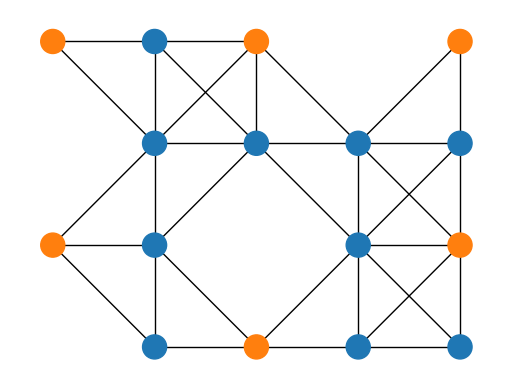

In [268]:
# Crate graph
graph = nx.Graph()
for i, pos in enumerate(pos_list):
    graph.add_node(i, pos = pos)
    
for i in range(n_nodes-1):
    for j in range(i+1, n_nodes):
        if np.linalg.norm(pos_list[i] - pos_list[j]) <= radius:
            graph.add_edge(i,j)

ax = plt.subplot()
ax.set_aspect('equal', 'box')
node_color = np.array(["C0"]*nqbits)
solution = solutions_OPT[0]
# node_color[np.where(solution == 1)] = "C1"
inds = [14, 12, 8, 2, 4, 11]
# node_color[np.where(solution == 1)] = "C1"
node_color[inds] = "C1"
nx.draw(graph, pos_list, with_labels=False, ax = ax, node_color = node_color)
plt.savefig("graph_sol.pdf")

## MIS Hamiltonian

The cost function Hamiltonian is

$ H = -\sum_{i\in V} n_i + 2 \sum_{(i,j)\in E}n_in_j$, with vertices $V$ and edges $E$,

see arXiv:1801.08653.

Here population is expressed via Pauli operator

$n_i = (1-z_i)/2$

and

$n_in_j = (z_iz_j - z_i - z_j + 1)/4$

In [273]:
nqbits = len(graph.nodes)

# QUBO coefficients
Zi = -np.ones(nqbits)
Zij = np.zeros([nqbits, nqbits])

# Constgant coefficient to add to the Hamiltonian
constant_coeff = -nqbits/2
# Coefficiemnts for z operators
z_coefs = np.ones(nqbits)/2
terms = []
for i, j in list(graph.edges):
    terms.append(Term(coefficient=2/4, pauli_op="ZZ", qbits=[i,j]))
    
    z_coefs[i] -= 2/4
    z_coefs[j] -= 2/4
    constant_coeff += 2/4
    
    Zij[i,j] = 2
    
for i in graph.nodes:
    terms.append(Term(coefficient=z_coefs[i], pauli_op="Z", qbits=[i]))
        
hamiltonian = Observable(nqbits, pauli_terms=terms, constant_coeff=constant_coeff)

## Resource Hamiltonian in a Rydberg setup
As rersource Hamiltonian we use native interactions in Rydberg atoms as in Science 376, no. 6598 (2022): 1209-1215.

The mixing Hamilonian
$H_{\text{MIX}}=\sum_{i}\left(\Omega e^{i\phi}\left|0\right\rangle _{i}\left\langle 1\right|+\text{h.c.}\right).$

The cost Hamilonian
$H_{\text{cost}}=-\Delta\sum_{i}n_{i}+\sum_{i<j}V_{ij}n_{i}n_{j},$

with $V_{ij}\sim1/|r_i-r_j|^6$. Further we cut the interactions of atoms with $|r_i-r_j|$ greater than the maximum link  length of the MIS problem. We will use $\Omega$, $\phi$, and $\Delta$ in each layer as variational parameters.

In [274]:
# Define operations contributing to the resource Hamiltonians
from qat.lang.AQASM.gates import AbstractGate

def matrix_generator(Omega, phi):
    m00 = (np.exp(-1j*Omega) + np.exp(1j*Omega))/2
    m01 = (np.exp(-1j*(Omega+phi)) - np.exp(1j*(Omega-phi)))/2
    m10 = (np.exp(1j*(-Omega+phi)) - np.exp(1j*(Omega+phi)))/2
    m11 = m00
    return np.array([[m00, m01],[m10, m11]])
    
my_Rx = AbstractGate("Rx", [float, float], arity=1,
                     matrix_generator = matrix_generator
                    )

my_Rn = AbstractGate("Rn", [float], arity=1,
                     matrix_generator = lambda Delta : np.array([[1, 0], [0, np.exp( 1j * Delta)]])
                    )
                     
my_Rnn = AbstractGate("Rnn", [float], arity=2,
                     matrix_generator = lambda Vij : np.array([[1, 0, 0, 0], 
                                                                 [0, 1, 0, 0], 
                                                                 [0, 0, 1, 0], 
                                                                 [0, 0, 0, np.exp(-1j * Vij)]])
                    )

In [275]:
# Add H cost layer
def add_cost_layer(reg, graph, layer_ind):
    
    V = prog.new_var(float, 'V_%i'%layer_ind)
    nodes_pos_dict = nx.get_node_attributes(graph, 'pos')
    for i, j in list(graph.edges):
        pos_i = nodes_pos_dict[i]
        pos_j = nodes_pos_dict[j]
        d = np.linalg.norm(pos_i - pos_j)
        my_Rnn(V**2/d**6)(reg[i], reg[j])
    
    Delta = prog.new_var(float, 'Delta_%i'%layer_ind)
    for i in graph.nodes:
        my_Rn(-Delta)(reg[i])

# Add H MIX layer
def add_MIX_layer(reg, layer_ind):
    nqbits = len(reg.qbits)
    Omega = prog.new_var(float, 'Omega_%i'%layer_ind)
    phi = prog.new_var(float, 'phi_%i'%layer_ind)
    for q in reg:
        my_Rx(Omega, phi)(q)

## Optimising variational circuit

In [276]:
from qat.lang.AQASM import Program
prog = Program()
reg = prog.qalloc(n_nodes)

# Number of layers
n_layers = 5
for i in range(n_layers):
    add_MIX_layer(reg, i)
    add_cost_layer(reg, graph, i)

circ = prog.to_circ()
# circ.display()

In [254]:
# Parameters of circuit
print(circ.get_variables())

['Delta_0', 'Delta_1', 'Delta_2', 'Delta_3', 'Delta_4', 'Omega_0', 'Omega_1', 'Omega_2', 'Omega_3', 'Omega_4', 'V_0', 'V_1', 'V_2', 'V_3', 'V_4', 'phi_0', 'phi_1', 'phi_2', 'phi_3', 'phi_4']


In [255]:
# circ.display() 

In [256]:
# Initial parameterss
Delta_list = np.linspace(-10, 10, n_layers)
V_list = np.ones(n_layers)*20
# V_list = Delta_list
Omega_list = np.ones(n_layers)*10
Omega_list[0] = 1
Omega_list[-1] = 1
phi_list = np.ones(n_layers)*0
x0 = np.concatenate([Delta_list, V_list, Omega_list, phi_list])

In [313]:
%matplotlib widget
import matplotlib.pyplot as plt
import hashlib  # To hash incoming jobs
from qat.core.plugins import AbstractPlugin


class WidgetPlugin(AbstractPlugin):
    def __init__(self):
        super(WidgetPlugin, self).__init__()
        # Widget
        # self.line = None
        # self.fig = None
        # self.ax = None
        # # Data being drawn
        # self.x, self.y = None, None
        
#     def reset(self):
#         """ Initializing a widget """
#         self.x = []
#         self.y = []
#         fig = plt.figure()
#         ax = fig.add_subplot(1, 1, 1)
#         line, = ax.plot(self.x, self.y)
#         self.widget = line
#         self.fig = fig
#         self.ax = ax
#         self.fig.show()

#     def update_plot(self, value):
#         """ Updating the current plot"""
#         # Updating data
#         self.x.append(len(self.x))
#         self.y.append(value)
#         # Updating widget
#         self.widget.set_data(self.x, self.y)
#         # Updating axes limits
#         self.ax.set_xlim(( 0, len(self.x)))
#         self.ax.set_ylim((min(self.y) - 1e-1, max(self.y)+1e-1))
#         # Redrawing widget
#         self.fig.canvas.draw()

    def compile(self, batch, _):
        return batch

    def post_process(self, batch_result):
        # self.update_plot(batch_result.results[0].value)
        print(batch_result.results[0].value)
        return batch_result

In [306]:
# params_valures = np.random.rand(circuit.num_parameters)
# NumLayers = n_nodes
omega = np.ones(n_layers)
omega[0] = 0.01
omega[-1] = 0.01
phi = np.zeros(n_layers)
# delta = np.linspace(-1, 1, n_layers-1)
# V = np.ones(n_layers-1)
delta = np.linspace(-1, 1, n_layers)
V = np.ones(n_layers)
params_in = np.concatenate([delta, V, omega, phi])

In [ ]:
# We use SPSA optimiser
# a, b, c, d = [0.01, 0.3, 0.15, 0.1]
# b = c2
# learning_rate = a * np.arange(1, maxiter + 1) ** (-b)
# perturbation = c * np.arange(1, maxiter + 1) ** (-d)
display = WidgetPlugin()

a = 0.01
c = 0.15
alpha = 0.3
gamma = 0.1
# spsa = SPSAMinimizePlugin(x0=params_in, maxiter = 10, precision = 1e-3, a = a, alpha = alpha, c = c, gamma = gamma)
 # | display
job = circ.to_job(job_type="OBS",
                  observable=hamiltonian,
                  nbshots=0)

# qpu = get_default_qpu()
# stack = spsa | qpu | display

stack = SPSAMinimizePlugin(x0=params_in, maxiter = 1000, precision = 1e-3, a = a, alpha = alpha, c = c, gamma = gamma) | display | get_default_qpu()

result = stack.submit(job)
print("Final energy:", result.value)

Final energy: -1.5138396541463375


In [284]:
result.meta_data["parameter_map"]

"{'Delta_0': -9.818314343696795, 'Delta_1': -5.3435076991858885, 'Delta_2': 0.5764215843224676, 'Delta_3': 5.473617585016292, 'Delta_4': 9.834363845306015, 'Omega_0': 19.872932710368158, 'Omega_1': 19.603852012363884, 'Omega_2': 19.7192112866235, 'Omega_3': 19.523872276259045, 'Omega_4': 19.55071282348246, 'V_0': 0.9684900151585065, 'V_1': 10.2111863397629, 'V_2': 10.64247820565312, 'V_3': 10.439065003976236, 'V_4': 0.5564533727008696, 'phi_0': -0.3614603525583662, 'phi_1': 0.20544579054449322, 'phi_2': -0.2835069688628456, 'phi_3': -0.10815208542507396, 'phi_4': -0.585087936193595}"

## Sample at the optimial parameters

In [323]:
# Converting bits string into energy using paraameters of the QUBO problem
def energy_from_samples(bits_string, Zi,Zij):
    
    N = len(Zi)
    
    bits = bits_string[None,:]
    E_Z_i = np.sum(bits*Zi)
    
    bits_2D = np.repeat(bits, N, 0)
    parity_matrix = bits_2D*bits.T
    E_Z_ij = np.sum(np.triu(Zij*parity_matrix, k = 1))
        
    return E_Z_i+E_Z_ij

# Helper function to get energies from samples
def _get_energies_from_samples(sol_res):
    
    # States converted to bits strings
    states_list = []
    # Energy of the states
    E_list = []
    # Energies of each shot
    E_list_shots = []
    # Total sampled energy
    E_sampled = 0
    for sample in sol_res:
        # State
        # state = 1 - np.array([int(i) for i in ("{:0%ib}"%nqbits).format(sample._state)])
        state = np.array([int(i) for i in ("{:0%ib}"%nqbits).format(sample._state)])
        states_list += [state]
        # Number of shots giving this state
        shots = int(sample.probability*nbshots)

        # Energy
        e = energy_from_samples(state,Zi,Zij)
        E_list += [e]
        E_list_shots += [e]*shots
        E_sampled += e*sample.probability

    E_min = min(E_list)
    solutions = np.array(states_list)[np.where(E_list==E_min)]
    
    return E_list_shots, E_sampled, E_min, solutions

In [324]:
#Binding the variables:
nbshots = 10000

# Sample with optimal parameters
sol_job = job(**eval(result.meta_data["parameter_map"]))
sampling_job = sol_job.circuit.to_job(nbshots = nbshots)
sol_res_OPT = qpu.submit(sampling_job)

E_list_shots_OPT, E_sampled_OPT, E_min_OPT, solutions_OPT = _get_energies_from_samples(sol_res_OPT)

# Sample with initial parameters
variables = {}
for v, x in zip(circ.get_variables(), x0):
    variables[v] = x
sol_job = job(**variables)
sampling_job = sol_job.circuit.to_job(nbshots = nbshots)
sol_res_IN = qpu.submit(sampling_job)

E_list_shots_IN, E_sampled_IN, E_min_IN, solutions_IN = _get_energies_from_samples(sol_res_IN)

print("Sampled energy:")
print("IN: %.3f, OPT: %.3f"%(E_sampled_IN, E_sampled_OPT))
print("")
print("Min energy:")
print("IN: %.3f, OPT: %.3f"%(E_min_IN, E_min_OPT))
print("")
print("Number solutions:")
print("IN: %i, OPT: %i"%(len(solutions_IN), len(solutions_OPT)))

Sampled energy:
IN: 6.828, OPT: -1.804

Min energy:
IN: -6.000, OPT: -6.000

Number solutions:
IN: 1, OPT: 4


Compare energy distributions

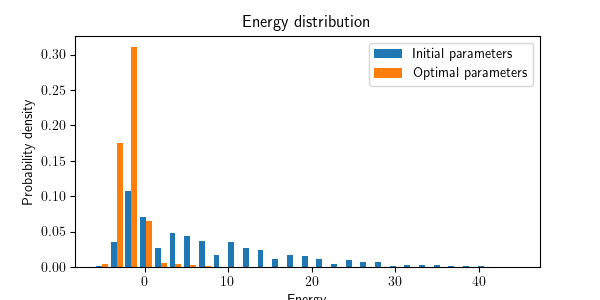

In [325]:
_, ax = plt.subplots(figsize = (6,3))
bins = np.linspace(
    min(min(E_list_shots_IN), min(E_list_shots_OPT)),
    max(max(E_list_shots_IN), max(E_list_shots_OPT)),
    30
)
ax.hist([E_list_shots_IN, E_list_shots_OPT], bins = bins, label =[ "Initial parameters", "Optimal parameters"], density = True);
# ax.hist(E_list_shots, bins = bins, label = "Optimal parameters", alpha = 0.5);
# ax.set_yscale("log")
ax.set_title("Energy distribution")
ax.set_xlabel("Energy")
ax.set_ylabel("Probability density")
ax.legend()

# plt.tight_layout()
plt.savefig("prob_density.pdf", dpi=4*72, bbox_inches="tight", format="pdf", pad_inches=0.02)

Now we plot the sampled optimal solutions

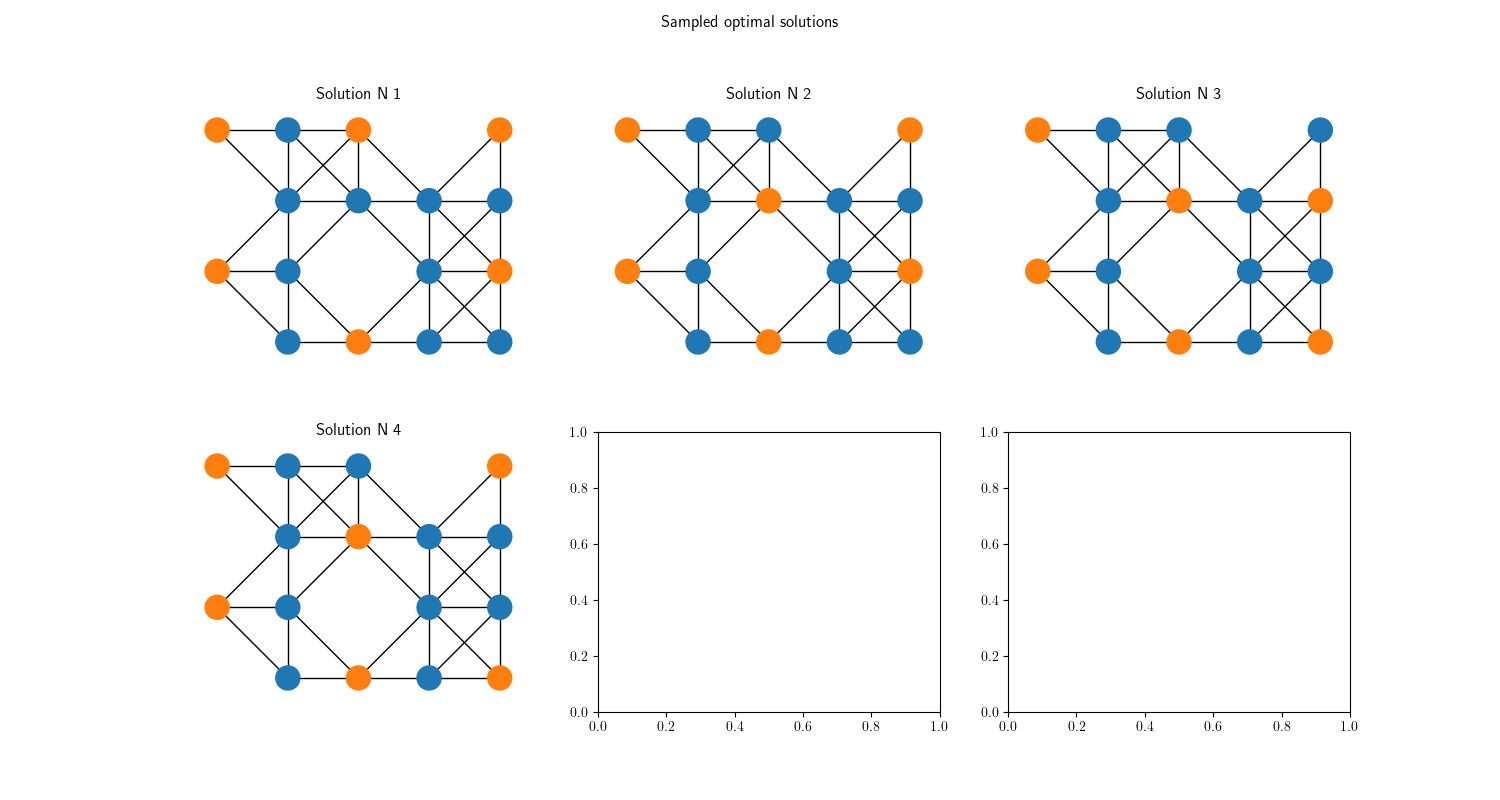

In [326]:
n_opt_sol = len(solutions_OPT)
n_col = min(3, n_opt_sol)
n_rows = n_opt_sol//n_col+n_opt_sol%n_col

fig, ax_list = plt.subplots(n_rows, n_col, figsize = (n_col*Lx, n_rows*Ly))
fig.suptitle("Sampled optimal solutions")
ax_list = np.ravel(ax_list)
for i, (solution, ax) in enumerate(zip(solutions_OPT, ax_list)):
    ax.set_title("Solution N %i"%(i+1))
    ax.set_aspect('equal', 'box')
    node_color = np.array(["C0"]*nqbits)
    node_color[np.where(solution == 1)] = "C1"
    nx.draw(graph, pos_list, with_labels=False, ax = ax, node_color = node_color)
    
plt.savefig("solutions.pdf")

## Resource Hamiltonian in a Rydberg setup
As rersource Hamiltonian we use native interactions in Rydberg atoms as in Science 376, no. 6598 (2022): 1209-1215.

The mixing Hamilonian
$H_{\text{MIX}}=\sum_{i}\left(\Omega e^{i\phi}\left|0\right\rangle _{i}\left\langle 1\right|+\text{h.c.}\right).$

The cost Hamilonian
$H_{\text{cost}}=-\Delta\sum_{i}n_{i}+\sum_{i<j}V_{ij}n_{i}n_{j},$

with $V_{ij}\sim1/|r_i-r_j|^6$. Further we cut the interactions of atoms with $|r_i-r_j|$ greater than the maximum link  length of the MIS problem. We will use $\Omega$, $\phi$, and $\Delta$ in each layer as variational parameters.

In [75]:
# Define operations contributing to the resource Hamiltonians
from qat.lang.AQASM.gates import AbstractGate

def matrix_generator(t1, t2):
    m00 = (np.exp(-1j*t1) + np.exp(1j*t1))/2
    m01 = (np.exp(-1j*(t1+t2)) - np.exp(1j*(t1-t2)))/2
    m10 = (np.exp(1j*(-t1+t2)) - np.exp(1j*(t1+t2)))/2
    m11 = m00
    return np.array([[m00, m01],[m10, m11]])
    
my_Rx = AbstractGate("Rx", [float, float], arity=1,
                     matrix_generator = matrix_generator
                    )

my_Rn = AbstractGate("Rn", [float], arity=1,
                     matrix_generator = lambda theta : np.array([[1, 0], [0, np.exp( -1j * theta)]])
                    )
                     
my_Rnn = AbstractGate("Rnn", [float], arity=2,
                     matrix_generator = lambda theta : np.array([[1, 0, 0, 0], 
                                                                 [0, 1, 0, 0], 
                                                                 [0, 0, 1, 0], 
                                                                 [0, 0, 0, -np.exp(1j * theta)]])
                    )

In [105]:
# Add H cost layer
def add_cost_layer(reg, graph, layer_ind):
    
    V = prog.new_var(float, 'V_%i'%layer_ind)
    nodes_pos_dict = nx.get_node_attributes(graph, 'pos')
    for i, j in list(graph.edges):
        pos_i = nodes_pos_dict[i]
        pos_j = nodes_pos_dict[j]
        d = np.linalg.norm(pos_i - pos_j)
        my_Rnn(V/d**6)(reg[i], reg[j])
    
    Delta = prog.new_var(float, 'Delta_%i'%layer_ind)
    for i in graph.nodes:
        my_Rn(-Delta)(reg[i])

# Add H MIX layer
def add_MIX_layer(reg, layer_ind, Omega):
    nqbits = len(reg.qbits)
    Omega = prog.new_var(float, 'Omega_%i'%layer_ind)
    phi = 0
    for q in reg:
        my_Rx(Omega, phi)(q)

## Optimising variational circuit

In [77]:
from qat.lang.AQASM import Program
prog = Program()
reg = prog.qalloc(n_nodes)

# Number of layers
n_layers = 5
Omega_list = np.ones(n_layers)
Omega_list[0] = 0
Omega_list[0] = 0
for i in range(n_layers):
    add_cost_layer(reg, graph, i)
    add_MIX_layer(reg, i, Omega)

circ = prog.to_circ()
# circ.display()

In [104]:
# Parameters of circuit
print(circ.get_variables())

['Delta_0', 'Delta_1', 'Delta_2', 'Omega_0', 'Omega_1', 'Omega_2', 'V_0', 'V_1', 'V_2', 'phi_0', 'phi_1', 'phi_2']


In [103]:
# circ.display() 

In [79]:
# Initial parameterss
Delta_list = np.linspace(0.1, 1, n_layers)
V_list = Delta_list
Omega_list = np.ones(n_layers)
Omega_list[0] = 0.1
Omega_list[-1] = 0.1
phi_list = np.ones(n_layers)*0
x0 = np.concatenate([Delta_list, V_list, Omega_list, phi_list])

In [80]:
# We use SPSA optimiser
spsa = SPSAMinimizePlugin(x0=x0, maxiter = 1000, precision = 1e-6)

In [81]:
job = circ.to_job(job_type="OBS",
                  observable=hamiltonian,
                  nbshots=0)

qpu = get_default_qpu()
stack = spsa | qpu
result = stack.submit(job)
print("Final energy:", result.value)

Final energy: -1.5138396541463375


## Sample at the optimial parameters

In [82]:
# Converting bits string into energy using paraameters of the QUBO problem
def energy_from_samples(bits_string, Zi,Zij):
    
    N = len(Zi)
    
    bits = bits_string[None,:]
    E_Z_i = np.sum(bits*Zi)
    
    bits_2D = np.repeat(bits, N, 0)
    parity_matrix = bits_2D*bits.T
    E_Z_ij = np.sum(np.triu(Zij*parity_matrix, k = 1))
        
    return E_Z_i+E_Z_ij

# Helper function to get energies from samples
def _get_energies_from_samples(sol_res):
    
    # States converted to bits strings
    states_list = []
    # Energy of the states
    E_list = []
    # Energies of each shot
    E_list_shots = []
    # Total sampled energy
    E_sampled = 0
    for sample in sol_res:
        # State
        # state = 1 - np.array([int(i) for i in ("{:0%ib}"%nqbits).format(sample._state)])
        state = np.array([int(i) for i in ("{:0%ib}"%nqbits).format(sample._state)])
        states_list += [state]
        # Number of shots giving this state
        shots = int(sample.probability*nbshots)

        # Energy
        e = energy_from_samples(state,Zi,Zij)
        E_list += [e]
        E_list_shots += [e]*shots
        E_sampled += e*sample.probability

    E_min = min(E_list)
    solutions = np.array(states_list)[np.where(E_list==E_min)]
    
    return E_list_shots, E_sampled, E_min, solutions

In [89]:
#Binding the variables:
nbshots = 10000

# Sample with optimal parameters
sol_job = job(**eval(result.meta_data["parameter_map"]))
sampling_job = sol_job.circuit.to_job(nbshots = nbshots)
sol_res_OPT = qpu.submit(sampling_job)

E_list_shots_OPT, E_sampled_OPT, E_min_OPT, solutions_OPT = _get_energies_from_samples(sol_res_OPT)

# Sample with initial parameters
variables = {}
for v, x in zip(circ.get_variables(), x0):
    variables[v] = x
sol_job = job(**variables)
sampling_job = sol_job.circuit.to_job(nbshots = nbshots)
sol_res_IN = qpu.submit(sampling_job)

E_list_shots_IN, E_sampled_IN, E_min_IN, solutions_IN = _get_energies_from_samples(sol_res_IN)

print("Sampled energy:")
print("IN: %.3f, OPT: %.3f"%(E_sampled_IN, E_sampled_OPT))
print("")
print("Min energy:")
print("IN: %.3f, OPT: %.3f"%(E_min_IN, E_min_OPT))
print("")
print("Number solutions:")
print("IN: %i, OPT: %i"%(len(solutions_IN), len(solutions_OPT)))


Sampled energy:
IN: 13.298, OPT: -1.522

Min energy:
IN: -5.000, OPT: -5.000

Number solutions:
IN: 4, OPT: 15


Compare energy distributions

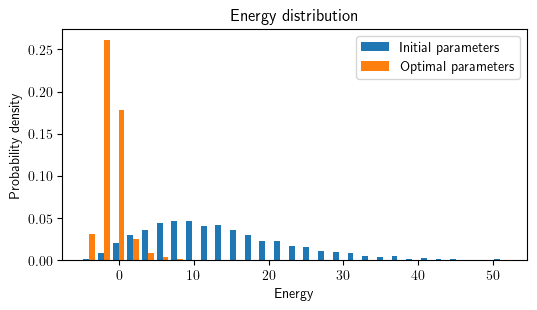

In [97]:
_, ax = plt.subplots(figsize = (6,3))
bins = np.linspace(
    min(min(E_list_shots_IN), min(E_list_shots_OPT)),
    max(max(E_list_shots_IN), max(E_list_shots_OPT)),
    30
)
ax.hist([E_list_shots_IN, E_list_shots_OPT], bins = bins, label =[ "Initial parameters", "Optimal parameters"], density = True);
# ax.hist(E_list_shots, bins = bins, label = "Optimal parameters", alpha = 0.5);
# ax.set_yscale("log")
ax.set_title("Energy distribution")
ax.set_xlabel("Energy")
ax.set_ylabel("Probability density")
ax.legend()

# plt.tight_layout()
plt.savefig("prob_density.pdf", dpi=4*72, bbox_inches="tight", format="pdf", pad_inches=0.02)

As we can see the initial parametes already give a gud resul, but the optimization can significatly increases the probability of sampling the optimal solution. However, that might not happen since the resource Hamiltonian is not equivalent to the cost Hamiltionian and, therefore, minimization of the energy does not garantee the intcrease of the probability to sample the lowest energy state.

Now we plot the sampled optimal solutions

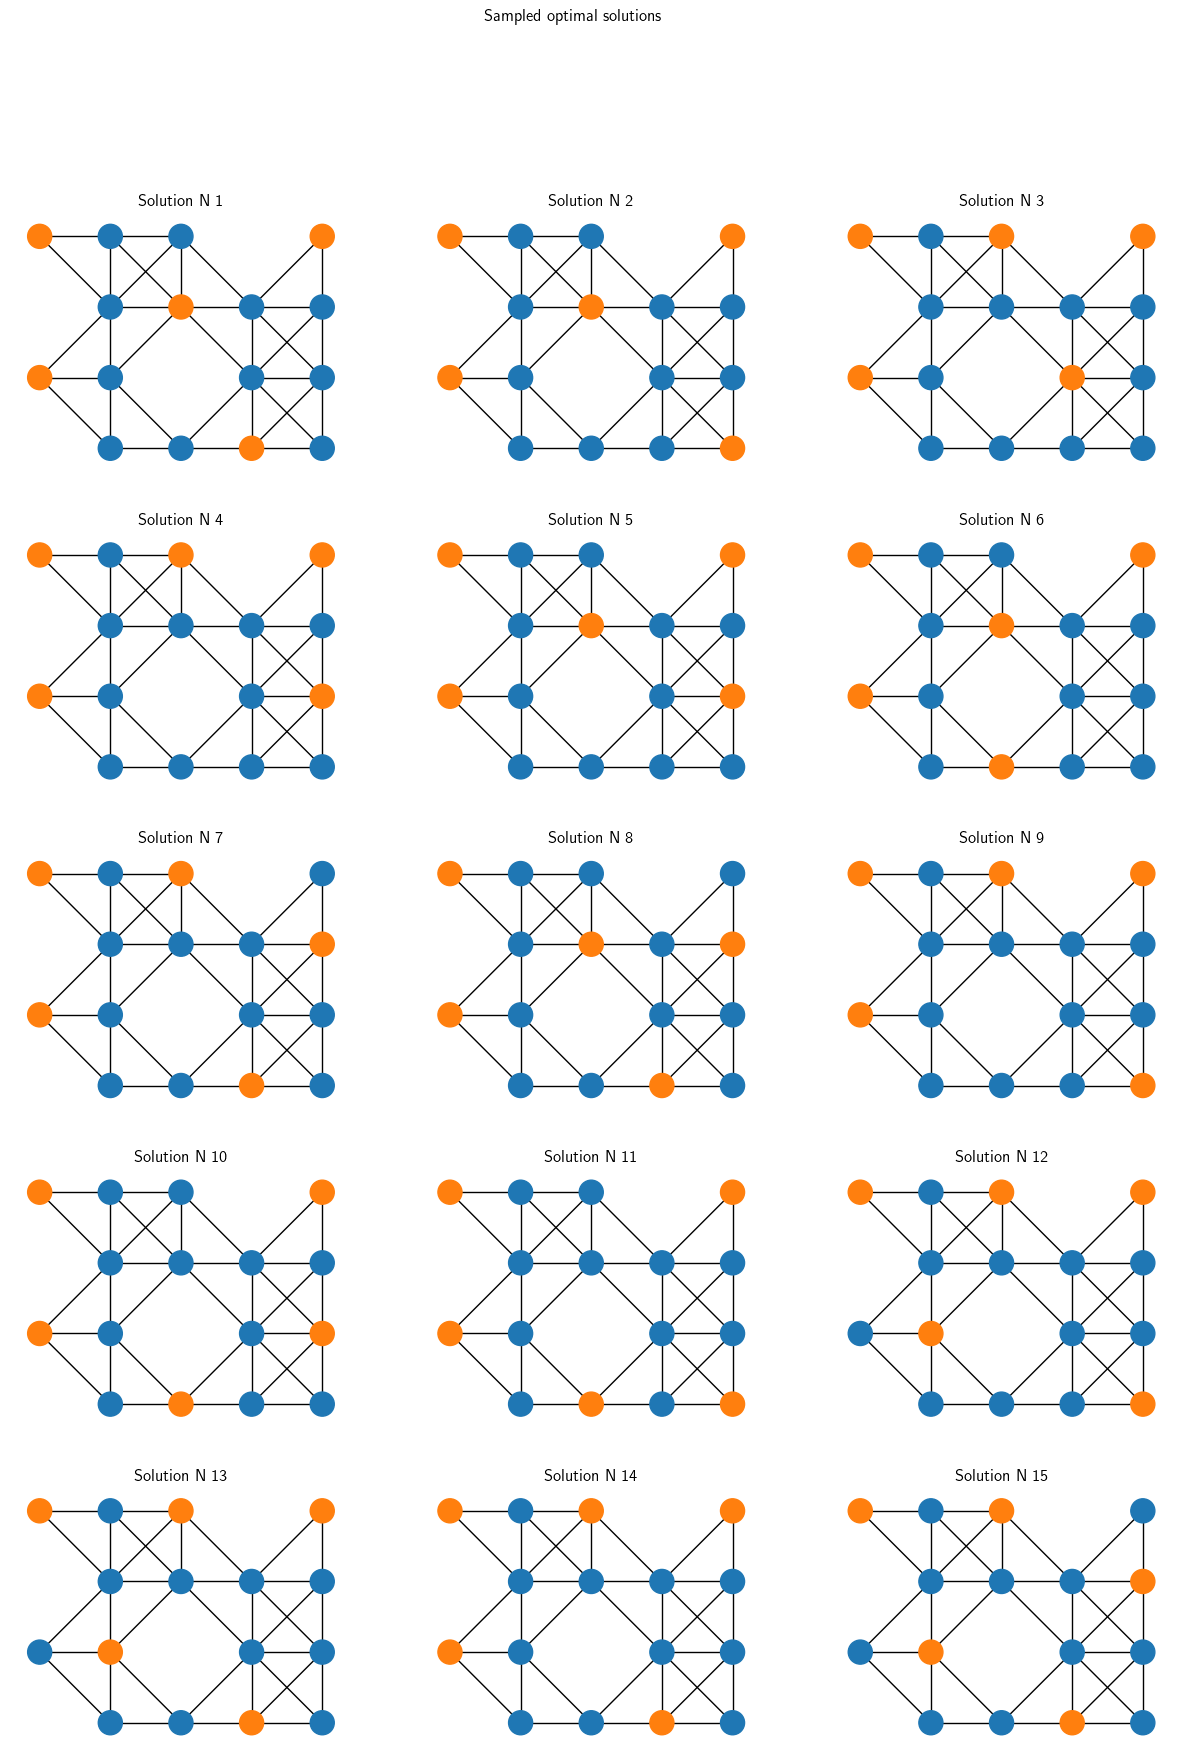

In [98]:
n_opt_sol = len(solutions_OPT)
n_col = min(3, n_opt_sol)
n_rows = n_opt_sol//n_col+n_opt_sol%n_col

fig, ax_list = plt.subplots(n_rows, n_col, figsize = (n_col*Lx, n_rows*Ly))
fig.suptitle("Sampled optimal solutions")
ax_list = np.ravel(ax_list)
for i, (solution, ax) in enumerate(zip(solutions_OPT, ax_list)):
    ax.set_title("Solution N %i"%(i+1))
    ax.set_aspect('equal', 'box')
    node_color = np.array(["C0"]*nqbits)
    node_color[np.where(solution == 1)] = "C1"
    nx.draw(graph, pos_list, with_labels=False, ax = ax, node_color = node_color)
    
plt.savefig("solutions.pdf")

# Ising model

In [342]:
nqbits = 8
h = 1.5

terms = []
for i in range(nqbits-1):
    terms.append(Term(coefficient=-1, pauli_op="ZZ", qbits=[i,i+1]))
    
for i in range(nqbits):
    terms.append(Term(coefficient=h, pauli_op="X", qbits=[i]))
        
hamiltonian = Observable(nqbits, pauli_terms=terms)

## Optimising variational circuit

In [345]:
# Add H cost layer
def add_nn_layer(reg, layer_ind, d_max = 2):
    nqubits = len(reg.qbits)
    V = prog.new_var(float, 'V_%i'%layer_ind)
    for d in range(1, d_max+1):
        for i in range(nqubits-d):
            my_Rnn(V/d**6)(reg[i], reg[i+d])
            
def add_n_layer(reg, layer_ind):
    Delta = prog.new_var(float, 'Delta_%i'%layer_ind)
    for q in reg:
        my_Rn(-Delta)(reg[i])
        
def add_x_layer(reg, layer_ind):
    Omega = prog.new_var(float, 'Omega_%i'%layer_ind)
    phi = prog.new_var(float, 'phi_%i'%layer_ind)
    for q in reg:
        my_Rx(Omega, phi)(q)

In [346]:
from qat.lang.AQASM import Program
prog = Program()
reg = prog.qalloc(nqbits)

# Number of layers
n_layers = 3
for i in range(n_layers):
    add_nn_layer(reg, i)
    add_n_layer(reg, i)
    add_x_layer(reg, i)
    
circ = prog.to_circ()
# circ.display()

In [347]:
# Parameters of circuit
print(circ.get_variables())

['Delta_0', 'Delta_1', 'Delta_2', 'Omega_0', 'Omega_1', 'Omega_2', 'V_0', 'V_1', 'V_2', 'phi_0', 'phi_1', 'phi_2']


In [348]:
# Initial parameterss
Delta_list = np.linspace(0.1, 1, n_layers)
V_list = Delta_list
Omega_list = np.ones(n_layers)
Omega_list[0] = 0.1
Omega_list[-1] = 0.1
phi_list = np.ones(n_layers)*0
x0 = np.concatenate([Delta_list, V_list, Omega_list, phi_list])

In [353]:
# We use SPSA optimiser
# optimiser = SPSAMinimizePlugin(x0=x0, maxiter = 1000, precision = 1e-6)
optimiser = ScipyMinimizePlugin(tol=1e-6, 
                             method="COBYLA", 
                             options={"maxiter": 1000})

In [354]:
job = circ.to_job(job_type="OBS",
                  observable=hamiltonian,
                  nbshots=0)

qpu = get_default_qpu()
stack = optimiser | qpu
result = stack.submit(job)
print("Final energy:", result.value)

Final energy: -12.178794239542908
